In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sai-vessel-segmentation2/all/test/10_test.tif
/kaggle/input/sai-vessel-segmentation2/all/test/15_test.tif
/kaggle/input/sai-vessel-segmentation2/all/test/19_test.tif
/kaggle/input/sai-vessel-segmentation2/all/test/05_test.tif
/kaggle/input/sai-vessel-segmentation2/all/test/06_test.tif
/kaggle/input/sai-vessel-segmentation2/all/test/18_test.tif
/kaggle/input/sai-vessel-segmentation2/all/test/01_test.tif
/kaggle/input/sai-vessel-segmentation2/all/test/13_test.tif
/kaggle/input/sai-vessel-segmentation2/all/test/07_test.tif
/kaggle/input/sai-vessel-segmentation2/all/test/16_test.tif
/kaggle/input/sai-vessel-segmentation2/all/test/04_test.tif
/kaggle/input/sai-vessel-segmentation2/all/test/20_test.tif
/kaggle/input/sai-vessel-segmentation2/all/test/11_test.tif
/kaggle/input/sai-vessel-segmentation2/all/test/08_test.tif
/kaggle/input/sai-vessel-segmentation2/all/test/09_test.tif
/kaggle/input/sai-vessel-segmentation2/all/test/17_test.tif
/kaggle/input/sai-vessel-segmentation2/a

1. Here we are using vgg16 pretrained networks for encoder for having good start but for center part and decoder we are using random initialization 
2. so we can do like train decoder and center for few epoches and do not backpropogate into encoder 
3. and then once all the wts and biases are at same level then train entire network onces for few epoches

4. for training purpose also we have total 20 images so first of all 16 image will be trained and 4 images will be used for validation and after validation we will train furture for all 20 images (here i have created new datset like train_dataset_all because eralier train_dataset will have only 16 images

In [2]:
import torch
import torch.nn as nn
from torchvision.models import vgg16_bn,VGG16_BN_Weights #here we are using batch normalized version of 
# vgg16 and it is available in torchvision.models here also vgg16_bn is just an architecture but for it's 
#weights we need VGG16_BN_Weights
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import os
import PIL
from PIL import Image
from torchvision.transforms import Normalize, ToTensor, Compose
from matplotlib import pyplot as plt
import math
import pandas as pd

In [30]:
vgg16 = models.vgg16_bn()
# vgg16.load_state_dict(torch.load("../input/vgg16bn/vgg16_bn.pth"))
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
# features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
# vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)


1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

<!-- 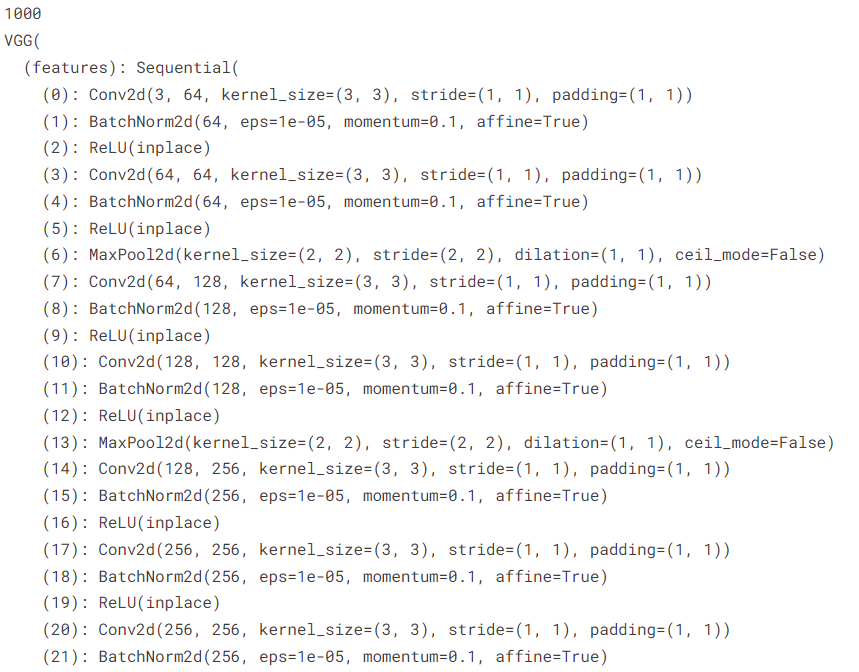
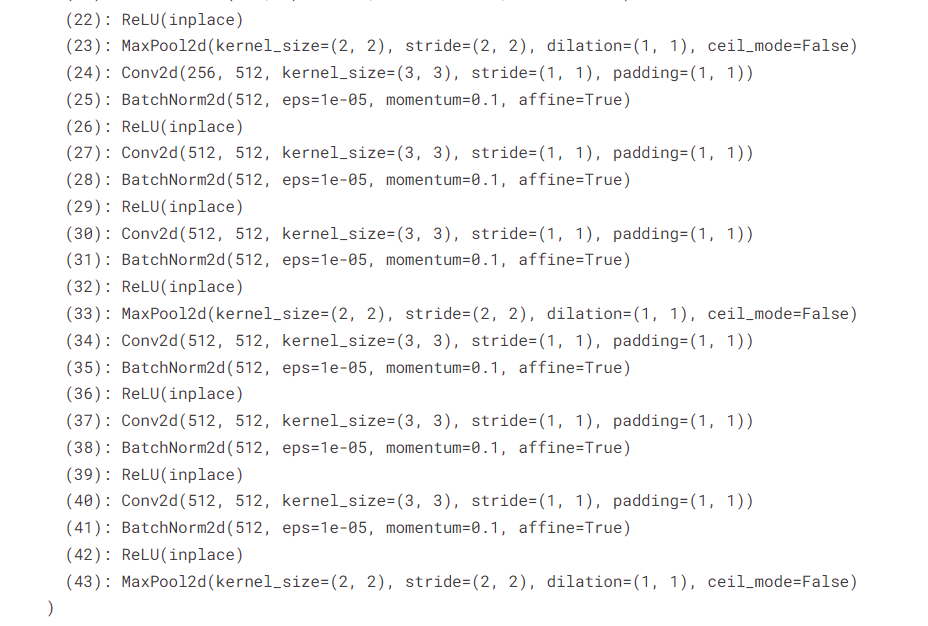
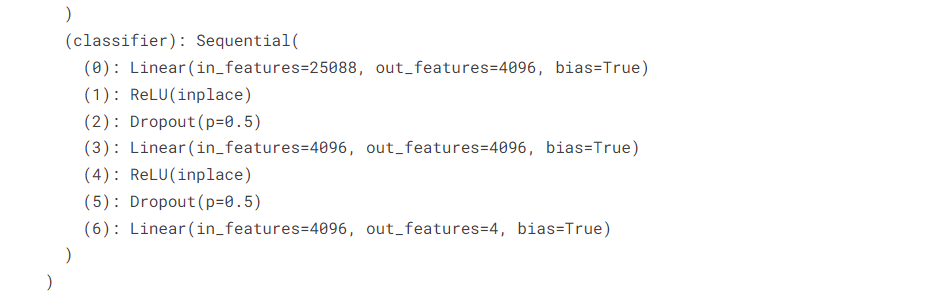 -->

In [3]:
if torch.cuda.is_available():
    device=torch.device(type="cuda", index=0)
else:
    device=torch.device(type="cpu", index=0)

print(device)

cuda:0


Image Type: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Mask Type: <class 'PIL.GifImagePlugin.GifImageFile'>
Image Size: (565, 584)
Image Shape: (584, 565, 3) Mask Shape: (584, 565)
Unique in Mask: [  0 255]
Image Data Type: uint8
Mask Data Type: uint8


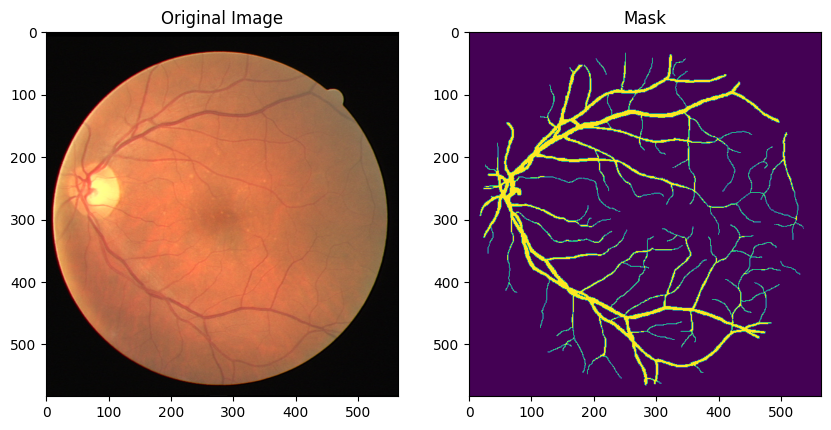

In [4]:
img=Image.open('/kaggle/input/sai-vessel-segmentation2/all/train/21_training.tif') #.tif is mask images a
mask=Image.open('/kaggle/input/sai-vessel-segmentation2/all/train/21_manual1.gif') #.gif is original images (like black and white)


print("Image Type:", type(img))
print("Mask Type:", type(mask))

print("Image Size:",img.size)

print("Image Shape:", np.array(img).shape, "Mask Shape:", np.array(mask).shape)

print("Unique in Mask:",np.unique(mask)) #it will be wither 0 or 255
print("Image Data Type:", np.array(img).dtype)
print("Mask Data Type:", np.array(mask).dtype)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)#creating 1 rwo and 2 colum and at 1st position put this image
plt.title("Original Image")
plt.imshow(img)
plt.subplot(1,2,2)#creating 1 rwo and 2 column and put this image at 2nd place
plt.title("Mask")
plt.imshow(mask)
plt.show()

In [6]:
def reshape_to_512(imgpath):
    ori_image = Image.open(imgpath)
    reshaped_image=ori_image.resize((512,512),PIL.Image.NEAREST)#our image is 584 X 565 but we are dealing with 512X512 (because submission accepts 512X512 size) 
    #so we need to resize it using PIL.Image.NEAREST interpolation method here nearest will not change the pixel values
    return reshaped_image

After Reshape:
Image Type: <class 'PIL.Image.Image'>
Mask Type: <class 'PIL.Image.Image'>
Image Shape: (512, 512, 3) Mask Shape: (512, 512) Image dtype: uint8 Mask dtype: uint8
Unique in Mask: [  0 255]
Number of Ones in Mask: 19531.0


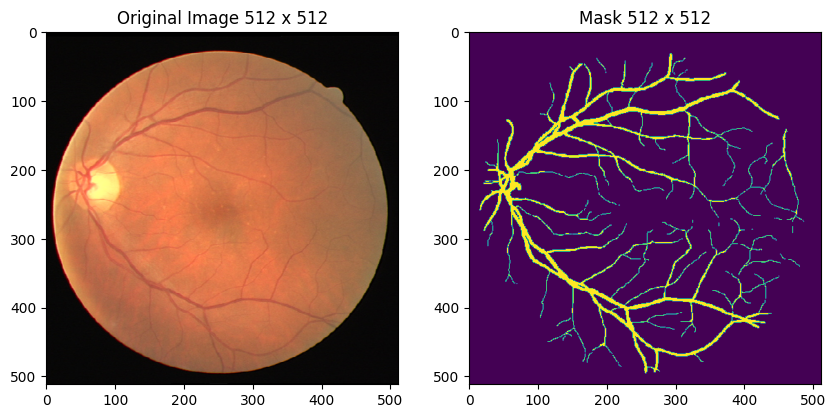

In [7]:
img=reshape_to_512("/kaggle/input/sai-vessel-segmentation2/all/train/21_training.tif")
mask=reshape_to_512("/kaggle/input/sai-vessel-segmentation2/all/train/21_manual1.gif")

print("After Reshape:")

print("Image Type:", type(img))
print("Mask Type:", type(mask))

print("Image Shape:",np.array(img).shape,"Mask Shape:",np.array(mask).shape,"Image dtype:",np.array(img).dtype,"Mask dtype:", np.array(mask).dtype)

print("Unique in Mask:",np.unique(mask))

print("Number of Ones in Mask:",np.sum(np.sum(np.array(mask)/255))) #finding avg how many ones are there so first row wise and then column wise

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image 512 x 512")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("Mask 512 x 512")
plt.imshow(mask)
plt.show()

In [8]:
class TrainDataset(Dataset):
    def __init__(self,path,transform=None):
        super().__init__()
        self.path=path
        _,_,self.filepaths=next(os.walk(path))# next(os.walk(self.imgpath)) will return 3 things 
#         1) path to root directory i.e. kaggle/temp/test
#         2) list of all the subdirectories
#         3) list of all the files that it contains
#         so _,_,self.files means we are not interested into first two thing i.e. path to root directory and 
#         list of all the subdirectory we only need all the images i.e. 3rd thing so we are storing it into
#         files variable like files will have list of all 40 (20 image and 20 masks)the images path
        self.length=int(len(self.filepaths)/2)-4 #/2 because we have 40 images so outof it 20 are image and 20 are mask 
    # and -4 bacause we want to use 4 images for validation purpose
        self.transform=Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
        
    
    def __len__(self):
        return self.length #it will be 16
    
    def __getitem__(self,idx):
        idx=idx+21 
        path=self.path + str(idx) + "_training.tif"
        img=reshape_to_512(path)
        img=self.transform(img) #it will do two things here ToTensor and normalize ( using that compose )
        
        path=self.path + str(idx) + "_manual1.gif"
        mask=reshape_to_512(path) #here we are not applying tarnsform because here is no problem with totensor becuse 
        #totensor makes value between 0 to 1 and here also we want that like 0 for backgroud and 1 for forground but in case 
        #if we have more than one class then it will reduce it between 0 and 1 so in that case tranform will not be ok
        # and another thing is that is is normalizing that values
        mask=np.array(mask)
        mask=torch.from_numpy(mask).type(torch.long)
        mask[mask==255]=1 #here we are doing that [0 255] to [0 1]
                      
        return img, mask

class ValDataset(Dataset):
    def __init__(self,path,transform=None):#here path will same as traing dataset but we will only access last 4 images path
        #for validation pupose 
        super().__init__()
        self.path=path
        _,_,self.filepaths=next(os.walk(path))
        self.length=int(len(self.filepaths)/2)-16 #here length will be 4
        self.transform=Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
        
    
    def __len__(self):
        return self.length
    
    def __getitem__(self,idx):
        idx=idx+37 # so +37 means we are accessing 37 then 38 then 39 and last 40
        path=self.path + str(idx) + "_training.tif"
        img=reshape_to_512(path)
        img=self.transform(img)
        
        path=self.path + str(idx) + "_manual1.gif"
        mask=reshape_to_512(path)
        mask=np.array(mask)
        mask=torch.from_numpy(mask).type(torch.long)
        mask[mask==255]=1
                      
        return img, mask

In [9]:
train_dataset=TrainDataset("/kaggle/input/sai-vessel-segmentation2/all/train/")

#train_dataset,val_dataset=torch.utils.data.random_split(train_dataset,[16,4])

val_dataset=ValDataset("/kaggle/input/sai-vessel-segmentation2/all/train/")

batch_size=4

train_dataloader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True) 

val_dataloader=DataLoader(dataset=val_dataset,batch_size=batch_size)

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Image dtype: torch.float32 Mask dtype: torch.int64
Unique in Mask: [0 1]


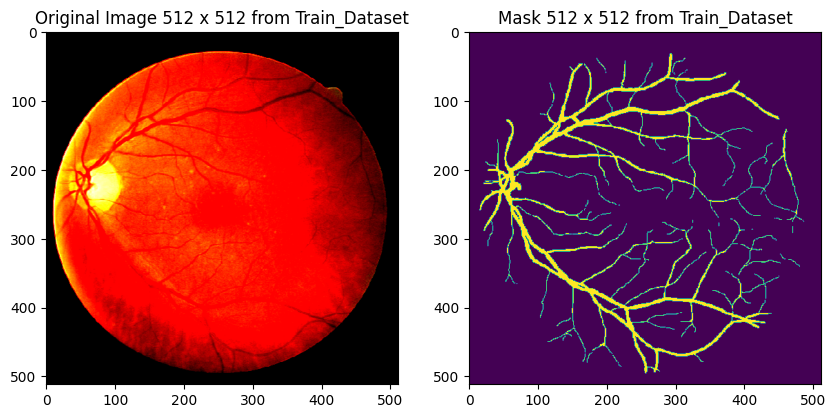

In [10]:
img,mask=train_dataset[0] #if we pick up it from DataLoader then only it will be shuffeled here it will be 21st image

print("Image Shape:",img.shape,"Mask Shape:",mask.shape,"Image dtype:",img.dtype, "Mask dtype:", mask.dtype)
print("Unique in Mask:",np.unique(mask)) #here because of ToTensor img.shape will be 3X512X512 and np.unique(mask) will be [0 1] (no of classes (IMP))
#Mask dtype: torch.int64 because we converted torch.long at above from uint8 

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image 512 x 512 from Train_Dataset")
plt.imshow(torch.permute(img,(1,2,0)))

plt.subplot(1,2,2)
plt.title("Mask 512 x 512 from Train_Dataset")
plt.imshow(mask)
plt.show()

In [11]:
class Unet(nn.Module):
    def __init__(self, encoder, center, decoder):
        super().__init__()
        self.encoder=encoder
        self.center=center
        self.decoder=decoder
        #self.dropout=nn.Dropout(p=0.2, inplace=True)
    
    def forward(self,x):
        encoder_features_outputs=self.encoder(x)#we also need that skip pointers for decoder so we need to store 
        #that intermediate outputs os encoder so we are storing it here like before maxpooling we are storing it's output 
        #so there will be intotal 44 because we have total 44 layers in vgg16 outputs [0,43] 
        #self.dropout(encoder_features_outputs[-1])
        center_output=self.center(encoder_features_outputs[-1])#here we are passing encoder's last output to center part as an input
        logits=self.decoder(center_output, encoder_features_outputs) #so here we are using that intermediate stored output
        #of encoder like decoder will need two things first is intermediate stored output of encoder and output of center part
        
        return logits

In [12]:
class Encoder(nn.Module):
    def __init__(self,pretrained_network): #here at time of creating instance of Encoder we have passed entire network so 
        #this pretrained_network will containt that all three things like features, avgpool and classifier 
        super().__init__()
        self.encoder=pretrained_network
    
    def forward(self,x): #here x will be the image on which we want to apply the Encoder
        encoder_features_outputs=[]
        for layer in self.encoder.features: # so here we are only processing the features but still we have remainng two things 
            #avgpool and classifier means we are only iterating through that 44 layers only
                x=layer(x) #applying i'th layer on that image
                encoder_features_outputs.append(x) #here we are storing that output after every layer
                        
        return encoder_features_outputs

In [1]:
class Center(nn.Sequential): #here we are not deriving it from nn.Module but for us we are not doing anythin extra for 
    #center part just we have 2-3 convolution layers so insted of inheriting from nn.Module we are inheriting nn.Sequential 
    #and hence why we are not writing forward method here
    def __init__(self):
        #here first will double the feature map and in second we are maintaining it.
        conv1=nn.Conv2d(in_channels=512,out_channels=1024, kernel_size=3,padding=1)
        bn1=nn.BatchNorm2d(num_features=1024)
        rl1=nn.ReLU()

        conv2=nn.Conv2d(in_channels=1024,out_channels=1024, kernel_size=3,padding=1)
        bn2=nn.BatchNorm2d(num_features=1024)
        rl2=nn.ReLU()
        
        super().__init__(conv1,bn1,rl1,conv2,bn2,rl2) #so from abover after creating structure of how we are processing in 
        #center part now we are calling parent class constructor and specifying in which order it will process

NameError: name 'nn' is not defined

In [14]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
               
        self.rl=nn.ReLU()
        self.conv5_up=nn.Conv2d(in_channels=1024,out_channels=512, kernel_size=3,padding=1)
        self.conv5_1=nn.Conv2d(in_channels=1024,out_channels=512, kernel_size=3,padding=1)
        self.bn5_1=nn.BatchNorm2d(num_features=512)
        self.conv5_2=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn5_2=nn.BatchNorm2d(num_features=512)
        self.conv5_3=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn5_3=nn.BatchNorm2d(num_features=512)
        
        self.conv4_up=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.conv4_1=nn.Conv2d(in_channels=1024,out_channels=512, kernel_size=3,padding=1)
        self.bn4_1=nn.BatchNorm2d(num_features=512)
        self.conv4_2=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn4_2=nn.BatchNorm2d(num_features=512)
        self.conv4_3=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn4_3=nn.BatchNorm2d(num_features=512)
        
        self.conv3_up=nn.Conv2d(in_channels=512,out_channels=256, kernel_size=3,padding=1)
        self.conv3_1=nn.Conv2d(in_channels=512,out_channels=256, kernel_size=3,padding=1)
        self.bn3_1=nn.BatchNorm2d(num_features=256)
        self.conv3_2=nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3,padding=1)
        self.bn3_2=nn.BatchNorm2d(num_features=256)
        self.conv3_3=nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3,padding=1)
        self.bn3_3=nn.BatchNorm2d(num_features=256)
        
        self.conv2_up=nn.Conv2d(in_channels=256,out_channels=128, kernel_size=3,padding=1)
        self.conv2_1=nn.Conv2d(in_channels=256,out_channels=128, kernel_size=3,padding=1)
        self.bn2_1=nn.BatchNorm2d(num_features=128)
        self.conv2_2=nn.Conv2d(in_channels=128,out_channels=128, kernel_size=3,padding=1)
        self.bn2_2=nn.BatchNorm2d(num_features=128)
        
        self.conv1_up=nn.Conv2d(in_channels=128,out_channels=64, kernel_size=3,padding=1)
        self.conv1_1=nn.Conv2d(in_channels=128,out_channels=64, kernel_size=3,padding=1)
        self.bn1_1=nn.BatchNorm2d(num_features=64)
        self.conv1_2=nn.Conv2d(in_channels=64,out_channels=64, kernel_size=3,padding=1)
        self.bn1_2=nn.BatchNorm2d(num_features=64)
        
        self.convfinal=nn.Conv2d(in_channels=64,out_channels=2,kernel_size=1)
    
    def forward(self,x, encoder_features_output):#x will be 16X16X1024
        x=F.interpolate(x,scale_factor=2, mode="nearest") #so it will double the size of image so 16X16X1024 to 32X32X1024
        x=self.conv5_up(x) #32X32X512
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[42]),dim=1) #output of encoder will also be 32X32X512 and now we are concating it
        # so depth wise concatination will be done so 32X32X(512+512) will be 32X32X1024 now we have to apply con->bn->relu
        #for 3 times like we have done in encoder so 9 layers will be processed here 
        x=self.conv5_1(x) #
        x=self.bn5_1(x)
        x=self.rl(x)
        x=self.conv5_2(x)#
        x=self.bn5_2(x)
        x=self.rl(x)
        x=self.conv5_3(x)#
        x=self.bn5_3(x)
        x=self.rl(x)
        
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv4_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[32]),dim=1)
        x=self.conv4_1(x)
        x=self.bn4_1(x)
        x=self.rl(x)
        x=self.conv4_2(x)
        x=self.bn4_2(x)
        x=self.rl(x)
        x=self.conv4_3(x)
        x=self.bn4_3(x)
        x=self.rl(x)
        
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv3_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[22]),dim=1)
        x=self.conv3_1(x)
        x=self.bn3_1(x)
        x=self.rl(x)
        x=self.conv3_2(x)
        x=self.bn3_2(x)
        x=self.rl(x)
        x=self.conv3_3(x)
        x=self.bn3_3(x)
        x=self.rl(x)
        
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv2_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[12]),dim=1)
        x=self.conv2_1(x)
        x=self.bn2_1(x)
        x=self.rl(x)
        x=self.conv2_2(x)
        x=self.bn2_2(x)
        x=self.rl(x)
        
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv1_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[5]),dim=1)
        x=self.conv1_1(x)
        x=self.bn1_1(x)
        x=self.rl(x)
        x=self.conv1_2(x)
        x=self.bn1_2(x)
        x=self.rl(x)
        
        logits=self.convfinal(x) #it will reduce no of feature maps to 2 (0 for background and 1 for forground ?) so 
        #logits will be 64 X 2
        
        return logits

In [15]:
def train_one_epoch(dataloader, model,loss_fn, optimizer):
    model.train()#now initializing UNET model for training purpose
    track_loss=0 #we are using DISC coefficient
    XintY=0 # |x intersection y|
    X=0
    Y=0
    for i, (imgs, masks) in enumerate(dataloader):#i will track betch number so 
        imgs=imgs.to(device) 
        masks=masks.to(device)
        
        preds=model(imgs) #images will be 4X3X512X512  and preds will be 4X2X512X512 so for 4 images there will be 2 values
        
        loss=loss_fn(preds,masks) #masks will be 4X512X512 now if we one hot encode it then 4X2X512X512 but here we are not doing that
        
        track_loss+=loss.item()
        
        predclass=torch.argmax(preds,dim=1) #by applying argmax we are changing to 4X1X512X512 or 4X512X512
        
        Y+=predclass.sum().item() #|X|
        X+=masks.sum().item()#|Y|

#now for intersection we don't want to find intersection of predicted BG and oririnal BG we only have to take intersection 
        #where pre=1 and mask=1 so we are changing the value of background to 2
#         000111       000111       222111       and mask will remain same so now if we check == then it will only compare 1's
#         010101       001011  -->  212121     
#         prediction   mask         prediction
        predclass[predclass==0]=2
        
        XintY+=(predclass==masks).type(torch.float).sum().item()
        
        print("Trainig Batch",i+1,":","2*XintY:",2*XintY,"X:",X,"Y:",Y, "X+Y:",X+Y)
        
        loss.backward()#this will calculate all the gradients
        optimizer.step()#it will calculate the equestion new_val_parameter=old_value_paramter-(lr)*(gradient_descent)
        optimizer.zero_grad()#it will prevent the accumulation of gradient since here we are dealing with batches To avoid this accumulation and ensure that each call to backward() 
#         computes gradients only for the current batch or computation step, you need to reset the gradients to zero. 
#         That's precisely the purpose of optimizer.zero_grad(). It clears the gradients of 
#         all optimized tensors so that you can compute the gradients for the new batch or computation step.

        running_loss=round(track_loss/(i+1),2)
        running_dice_coef=round(((2*XintY)/(X+Y)),2)
        
        print("Training Batch", i+1,":","/",len(dataloader), "Running Loss:",running_loss, "Running Dice_Coef:",running_dice_coef)
            
    epoch_loss=running_loss
    epoch_dice_coef=running_dice_coef    
    return epoch_loss, epoch_dice_coef


def val_one_epoch(dataloader, model,loss_fn):
    model.eval()
    track_loss=0
    XintY=0
    X=0
    Y=0
    with torch.no_grad():#because here for validation we will not be backpropogating we are just checking ther 
        #performance of 16 images using 4 image so we don't have to backpropogate hence torch.no_grad()
        for i, (imgs, masks) in enumerate(dataloader):
            imgs=imgs.to(device)
            masks=masks.to(device)
            
            preds=model(imgs)
            
            loss=loss_fn(preds,masks)
            
            track_loss+=loss.item()
            
            predclass=torch.argmax(preds,dim=1)
            
            Y+=predclass.sum().item()
            X+=masks.sum().item()
            
            predclass[predclass==0]=2
            
            XintY+=(predclass==masks).type(torch.float).sum().item()
            
            print("Validation Batch",i+1,":","2*XintY:",2*XintY,"X:",X,"Y:",Y, "X+Y:",X+Y)
            

            running_loss=round(track_loss/(i+1),2)
            running_dice_coef=round(((2*XintY)/(X+Y)),2)
            
            print("Validation Batch", i+1,":","/",len(dataloader), "Running Loss:",running_loss, "Running Dice_Coef:",running_dice_coef)
            
    epoch_loss=running_loss
    epoch_dice_coef=running_dice_coef    
    return epoch_loss, epoch_dice_coef

In [16]:
pretrained_network=vgg16_bn(weights=VGG16_BN_Weights.DEFAULT)

for param in pretrained_network.features.parameters(): 
    param.requires_grad=False #because firstly we are only training the center and decoder part so for encoder require_grad
    #must be false and later on we will mark it as true when we need to train entire network once. means here that wts and biases
    #of that 44 layers will not be updated

encoder=Encoder(pretrained_network).to(device)
center=Center().to(device)
decoder=Decoder().to(device)

model=Unet(encoder,center, decoder).to(device)

loss_fn=nn.CrossEntropyLoss()
lr=0.001
optimizer=torch.optim.Adam(params=model.parameters(), lr=lr)
n_epochs=40

for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_dice_coef=train_one_epoch(train_dataloader,model,loss_fn,optimizer)
    print("Training Epoch Loss:", train_epoch_loss, "Training Epoch Dice_Coef:", train_epoch_dice_coef)
    val_epoch_loss, val_epoch_dice_coef=val_one_epoch(val_dataloader,model,loss_fn)
    print("Validation Epoch Loss:", val_epoch_loss, "Validation Epoch Dice_Coef:", val_epoch_dice_coef)
    print("--------------------------------------------------")


for param in pretrained_network.features.parameters():
    param.requires_grad=True

n_epochs=40  
for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_dice_coef=train_one_epoch(train_dataloader,model,loss_fn,optimizer)
    print("Training Epoch Loss:", train_epoch_loss, "Training Epoch Dice_Coef:", train_epoch_dice_coef)
    val_epoch_loss, val_epoch_dice_coef=val_one_epoch(val_dataloader,model,loss_fn)
    print("Validation Epoch Loss:", val_epoch_loss, "Validation Epoch Dice_Coef:", val_epoch_dice_coef)
    print("--------------------------------------------------")

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:03<00:00, 159MB/s] 


Epoch No: 1
Trainig Batch 1 : 2*XintY: 115944.0 X: 81435 Y: 806506 X+Y: 887941
Training Batch 1 : / 4 Running Loss: 0.9 Running Dice_Coef: 0.13
Trainig Batch 2 : 2*XintY: 306532.0 X: 183650 Y: 1380486 X+Y: 1564136
Training Batch 2 : / 4 Running Loss: 0.85 Running Dice_Coef: 0.2
Trainig Batch 3 : 2*XintY: 461180.0 X: 268673 Y: 1830732 X+Y: 2099405
Training Batch 3 : / 4 Running Loss: 0.8 Running Dice_Coef: 0.22
Trainig Batch 4 : 2*XintY: 584024.0 X: 364581 Y: 2017381 X+Y: 2381962
Training Batch 4 : / 4 Running Loss: 0.74 Running Dice_Coef: 0.25
Training Epoch Loss: 0.74 Training Epoch Dice_Coef: 0.25
Validation Batch 1 : 2*XintY: 176026.0 X: 88013 Y: 1048576 X+Y: 1136589
Validation Batch 1 : / 1 Running Loss: 12.8 Running Dice_Coef: 0.15
Validation Epoch Loss: 12.8 Validation Epoch Dice_Coef: 0.15
--------------------------------------------------
Epoch No: 2
Trainig Batch 1 : 2*XintY: 144604.0 X: 96875 Y: 145990 X+Y: 242865
Training Batch 1 : / 4 Running Loss: 0.5 Running Dice_Coef: 0.

In [17]:
def plotres(img,pred,mask=None):
    img[0,:,:]=img[0,:,:]*0.229 + 0.485 #normalized=(original-(mean(g,r,b)))/(SD(r,g,b)) so for original we are simplifying this equestion
    img[1,:,:]=img[1,:,:]*0.224 + 0.456
    img[2,:,:]=img[2,:,:]*0.225 + 0.406
    if mask!=None:
        print("Image Shape:",img.shape,"Mask Shape:", mask.shape, "Pred Shape:",pred.shape, "Image dtype", img.dtype, "Mask dtype",mask.dtype, "Pred dtype",pred.dtype)
        print("Mask Unique:",mask.unique())
    else:
        print("Image Shape:",img.shape, "Pred Shape:", pred.shape, "Image dtype:",img.dtype, "Pred dtype:",pred.dtype)
    
    print("Pred Unique:",pred.unique())
    
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,3,1)
    plt.title("Original Image 512 x 512") #3X512X512
    plt.imshow(torch.permute(img.cpu(),(1,2,0))) #here to show image we need 512X512X3 so dimension wise we are purmuting
    
    if mask!=None:
        plt.subplot(1,3,2)
        plt.title("Mask Image  512 x 512")
        plt.imshow(mask.cpu())
    
    plt.subplot(1,3,3)
    plt.title("Predicted Image  512 x 512")
    plt.imshow(pred.cpu())
    plt.show()

On Validation Set: 2*XintY: 145728.0 X: 88013 Y: 92213 X+Y: 180226
Validation Dice Coef: 0.81
Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:0')
Pred Unique: tensor([0, 1], device='cuda:0')


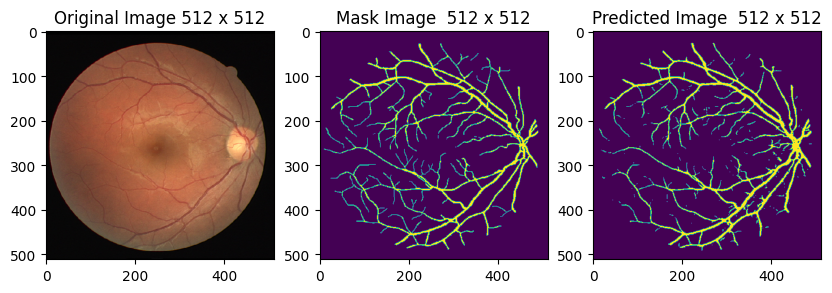

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:0')
Pred Unique: tensor([0, 1], device='cuda:0')


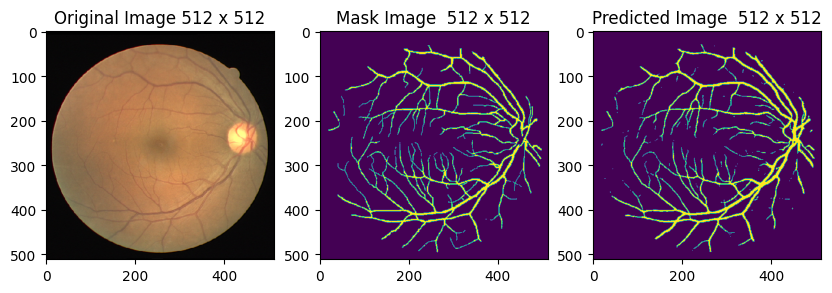

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:0')
Pred Unique: tensor([0, 1], device='cuda:0')


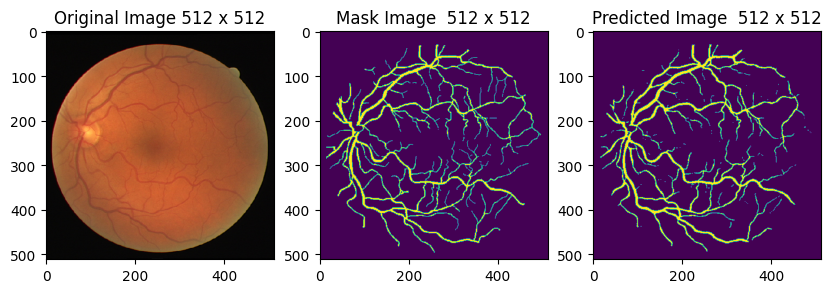

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:0')
Pred Unique: tensor([0, 1], device='cuda:0')


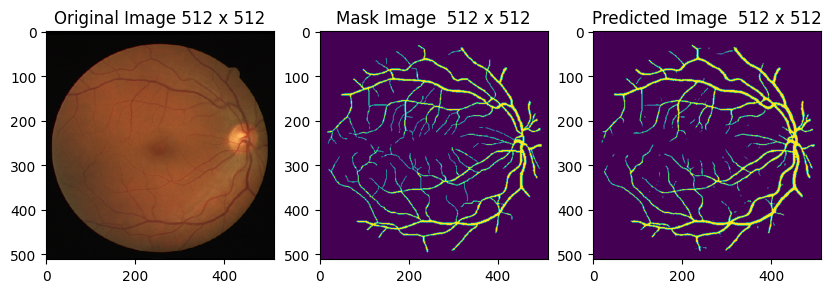

In [18]:
imgs,masks=next(iter(val_dataloader))
model.eval()

imgs=imgs.to(device)
masks=masks.to(device)

with torch.no_grad():
    preds=model(imgs)
    
    predclass=torch.argmax(preds,dim=1)
            
    Y=predclass.sum().item()
    X=masks.sum().item()
            
    predclass[predclass==0]=2
    
    XintY=(predclass==masks).type(torch.float).sum().item()
    
    print("On Validation Set:","2*XintY:",2*XintY,"X:",X,"Y:",Y, "X+Y:",X+Y)
    
    dice_coef=round((2*XintY)/(X+Y),2)
    
    
print("Validation Dice Coef:",dice_coef)

predclass[predclass==2]=0
plotres(imgs[0],predclass[0],masks[0])
plotres(imgs[1],predclass[1],masks[1])
plotres(imgs[2],predclass[2],masks[2])
plotres(imgs[3],predclass[3],masks[3])

In [ ]:
class TrainDatasetForAllImges(Dataset):
    def __init__(self,path,transform=None):
        super().__init__()
        self.path=path
        _,_,self.filepaths=next(os.walk(path))# next(os.walk(self.imgpath)) will return 3 things 
#         1) path to root directory i.e. kaggle/temp/test
#         2) list of all the subdirectories
#         3) list of all the files that it contains
#         so _,_,self.files means we are not interested into first two thing i.e. path to root directory and 
#         list of all the subdirectory we only need all the images i.e. 3rd thing so we are storing it into
#         files variable like files will have list of all 40 (20 image and 20 masks)the images path
        self.length=int(len(self.filepaths)/2) #/2 because we have 40 images so outof it 20 are image and 20 are mask 
    # and here we are not doing -4 bacause we want train again for all the images available in train dataset
        self.transform=Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
        
    
    def __len__(self):
        return self.length #it will be 20
    
    def __getitem__(self,idx):
        idx=idx+21 
        path=self.path + str(idx) + "_training.tif"
        img=reshape_to_512(path)
        img=self.transform(img) #it will do two things here ToTensor and normalize ( using that compose )
        
        path=self.path + str(idx) + "_manual1.gif"
        mask=reshape_to_512(path) #here we are not applying tarnsform because here is no problem with totensor becuse 
        #totensor makes value between 0 to 1 and here also we want that like 0 for backgroud and 1 for forground but in case 
        #if we have more than one class then it will reduce it between 0 and 1 so in that case tranform will not be ok
        # and another thing is that is is normalizing that values
        mask=np.array(mask)
        mask=torch.from_numpy(mask).type(torch.long)
        mask[mask==255]=1 #here we are doing that [0 255] to [0 1]
                      
        return img, mask

In [19]:
train_dataset=TrainDatasetForAllImges("/kaggle/input/sai-vessel-segmentation2/all/train/", "yes")

batch_size=4

n_epochs=40

train_dataloader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)

for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_dice_coef=train_one_epoch(train_dataloader,model,loss_fn,optimizer)
    print("Training Epoch Loss:", train_epoch_loss, "Training Epoch Dice_Coef:", train_epoch_dice_coef)
    print("--------------------------------------------------")

Epoch No: 1
Trainig Batch 1 : 2*XintY: 157978.0 X: 100564 Y: 87296 X+Y: 187860
Training Batch 1 : / 4 Running Loss: 0.07 Running Dice_Coef: 0.84
Trainig Batch 2 : 2*XintY: 302140.0 X: 186654 Y: 170570 X+Y: 357224
Training Batch 2 : / 4 Running Loss: 0.07 Running Dice_Coef: 0.85
Trainig Batch 3 : 2*XintY: 444900.0 X: 273569 Y: 253247 X+Y: 526816
Training Batch 3 : / 4 Running Loss: 0.07 Running Dice_Coef: 0.84
Trainig Batch 4 : 2*XintY: 594326.0 X: 364581 Y: 338879 X+Y: 703460
Training Batch 4 : / 4 Running Loss: 0.06 Running Dice_Coef: 0.84
Training Epoch Loss: 0.06 Training Epoch Dice_Coef: 0.84
--------------------------------------------------
Epoch No: 2
Trainig Batch 1 : 2*XintY: 149104.0 X: 91064 Y: 86279 X+Y: 177343
Training Batch 1 : / 4 Running Loss: 0.07 Running Dice_Coef: 0.84
Trainig Batch 2 : 2*XintY: 298842.0 X: 180686 Y: 171718 X+Y: 352404
Training Batch 2 : / 4 Running Loss: 0.06 Running Dice_Coef: 0.85
Trainig Batch 3 : 2*XintY: 444584.0 X: 268570 Y: 255248 X+Y: 523818

In [20]:
class TestDataset(Dataset):
    def __init__(self,path):
        super().__init__()
        self.path=path
        _,_,self.filepaths=next(os.walk(path))
        self.length=len(self.filepaths)
        self.transform=Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
    
    def __len__(self):
        return self.length#it will be 20 
    
    def __getitem__(self,idx):
        idx=idx+1
        if idx <= 9:
            path=self.path + "0" + str(idx) + "_test.tif"
        else:
            path=self.path + str(idx) + "_test.tif"
        
        img=reshape_to_512(path)
        img=self.transform(img)
        
        return img
    

In [21]:
torch.cuda.empty_cache()

In [22]:
test_dataset=TestDataset("/kaggle/input/sai-vessel-segmentation2/all/test/")

batch_size=2
test_dataloader=DataLoader(dataset=test_dataset,batch_size=batch_size)

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


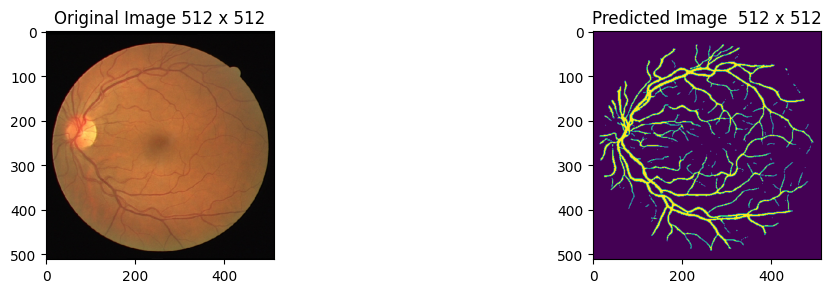

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


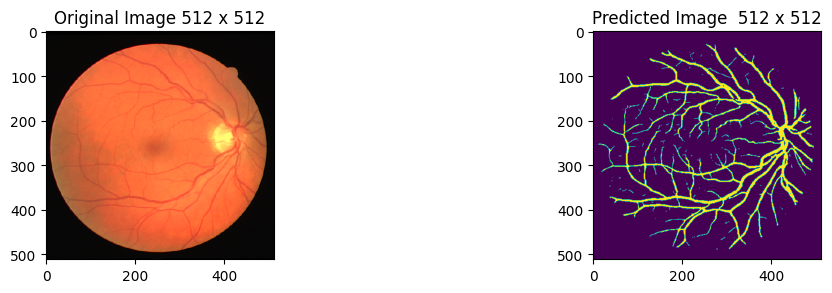

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


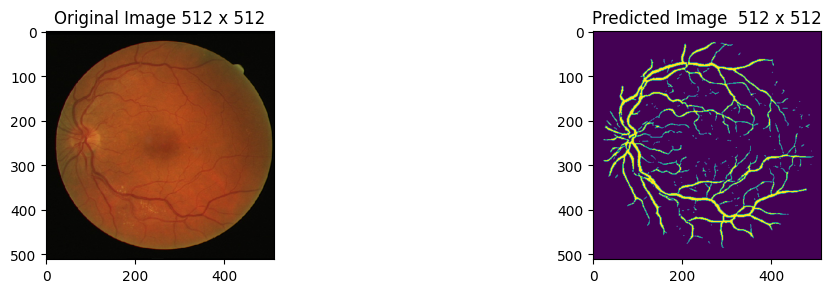

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


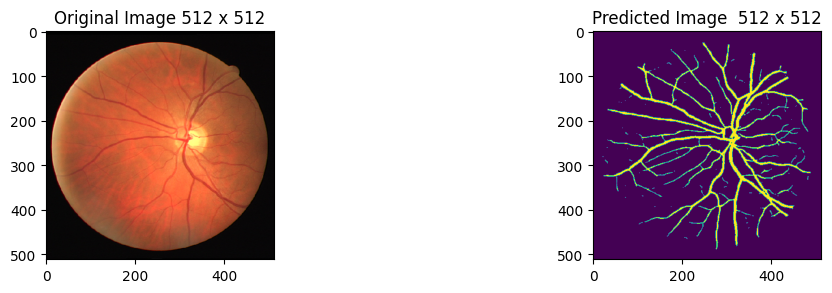

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


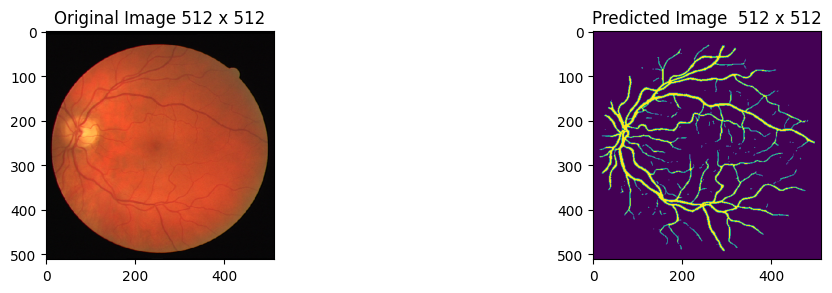

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


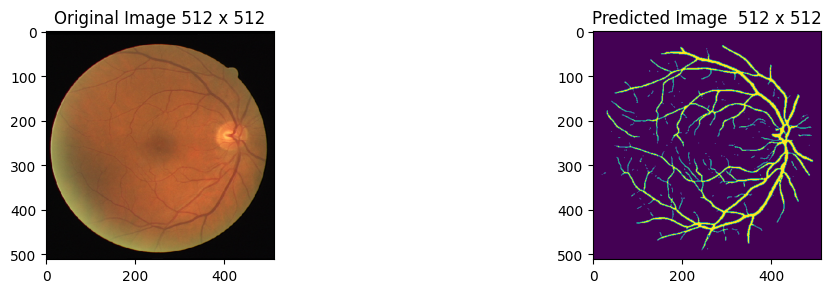

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


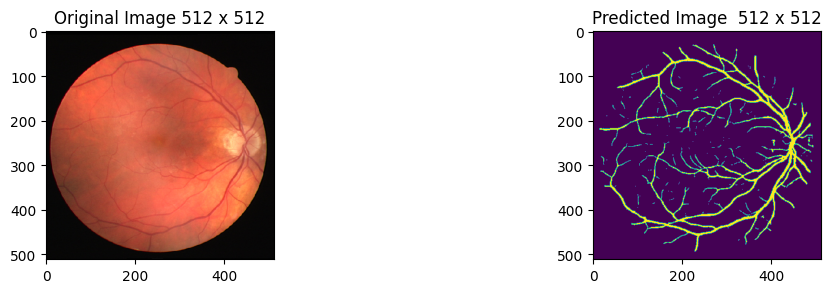

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


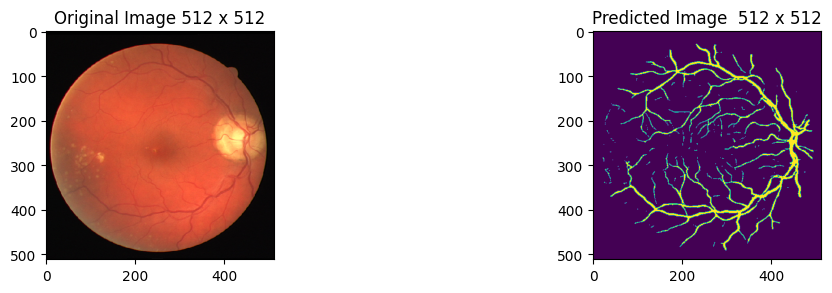

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


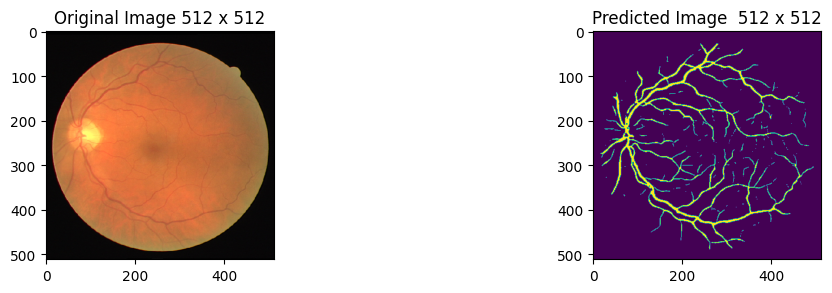

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


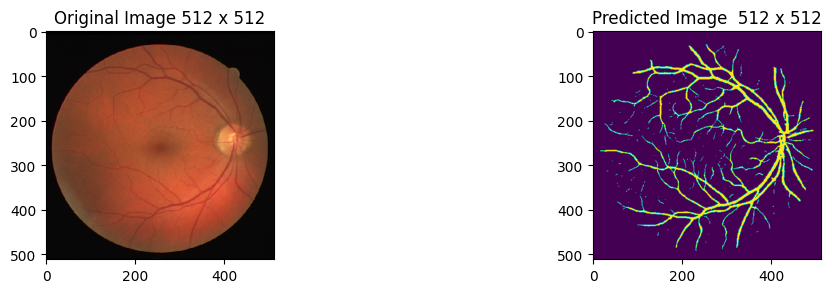

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


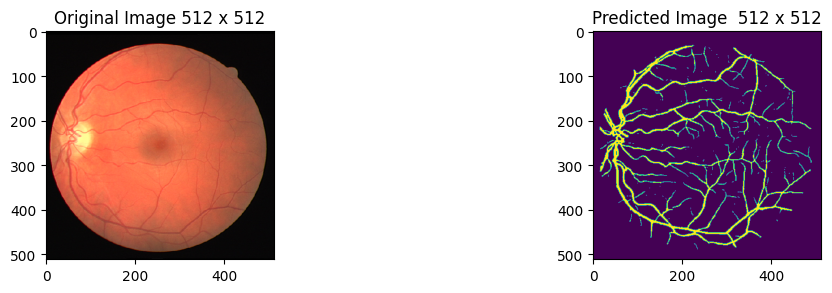

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


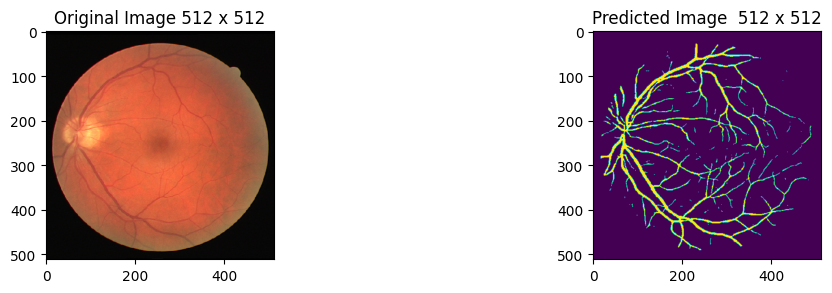

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


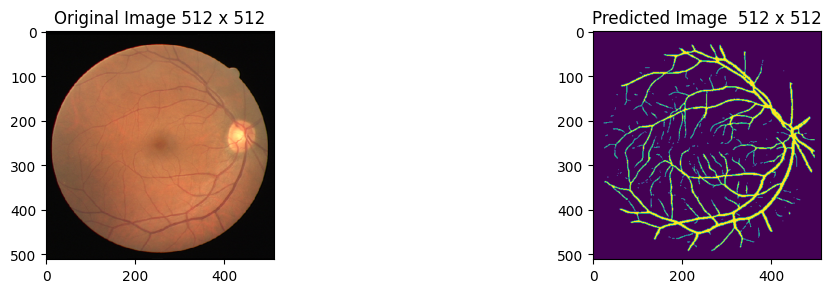

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


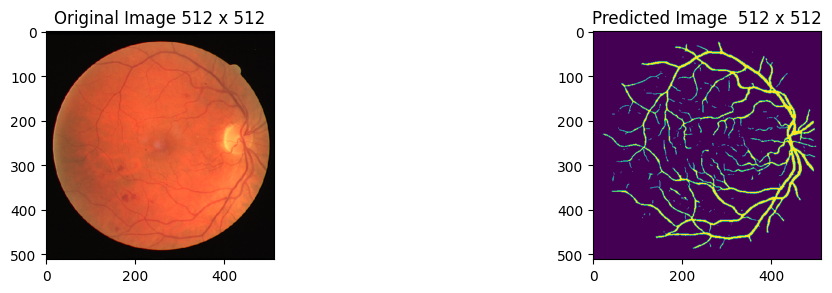

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


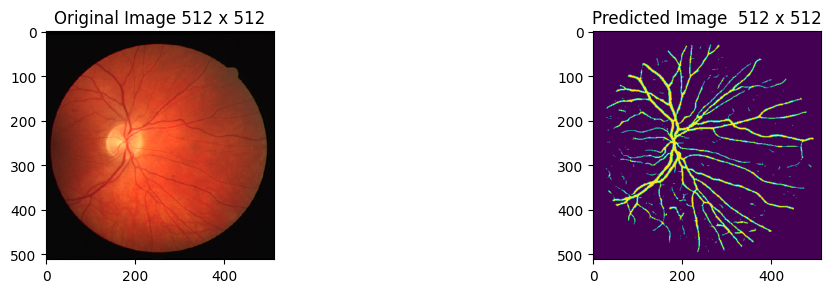

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


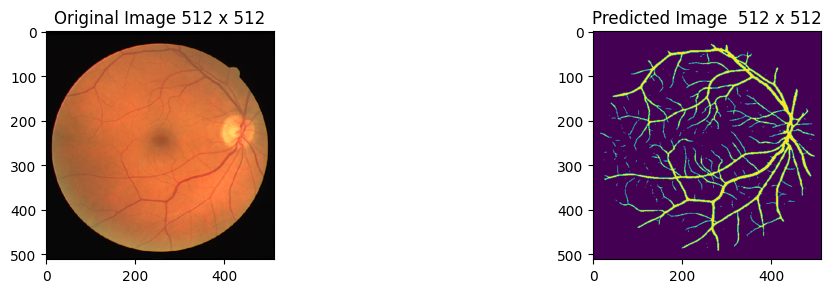

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


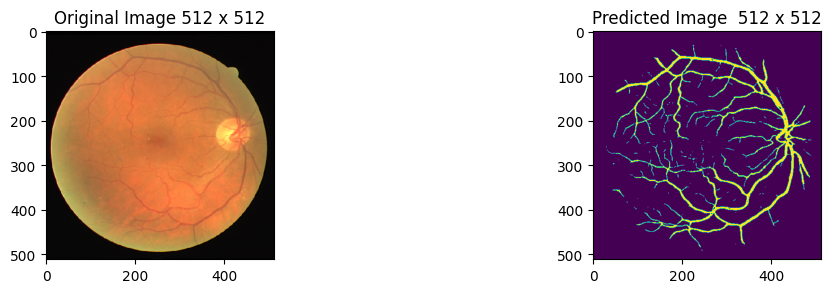

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


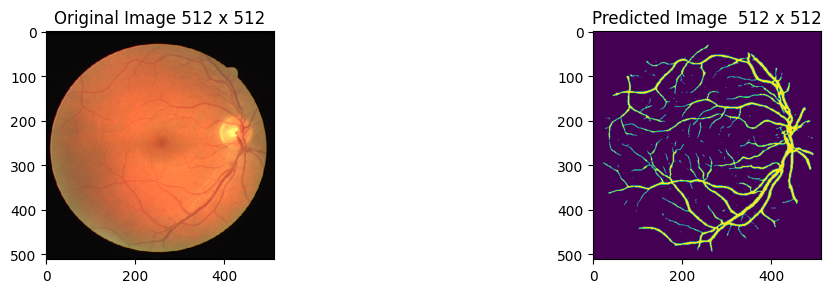

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


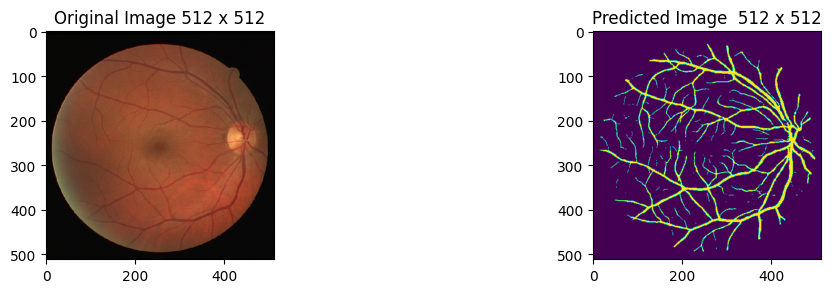

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


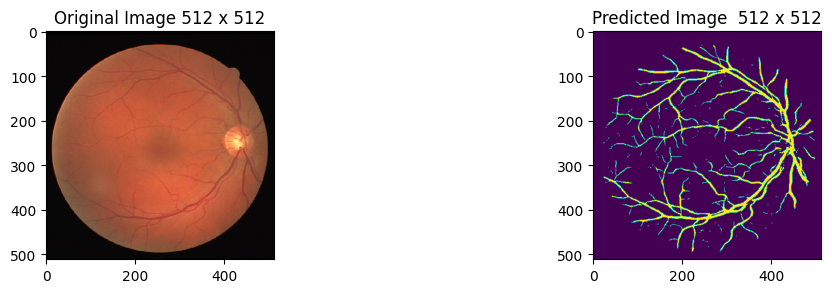

Id                                          Predicted
0    0  15594 1 15652 3 16104 3 16163 4 16616 3 16674 ...
1    1  15103 2 15615 3 16128 5 16146 2 16641 7 16659 ...
2    2  13070 6 13579 9 14089 8 14099 1 14112 5 14600 ...
3    3  13559 4 14071 5 14584 4 15096 5 15608 6 15664 ...
4    4  16132 1 16642 4 16676 2 17153 4 17187 6 17664 ...
5    5  16675 4 17187 4 17699 6 18212 7 18629 3 18725 ...
6    6  15631 2 16097 3 16103 2 16143 2 16609 10 16655...
7    7  15080 3 15592 4 15634 2 16105 4 16145 5 16617 ...
8    8  14578 1 14614 4 15090 2 15125 5 15602 3 15637 ...
9    9  15614 3 16127 3 16601 1 16639 3 17112 3 17152 ...
10  10  16097 1 16607 5 17104 5 17111 11 17614 19 1812...
11  11  14568 2 15079 4 15591 5 15640 2 16103 5 16151 ...
12  12  15624 2 16094 3 16136 3 16158 1 16607 4 16648 ...
13  13  12571 1 13082 3 13594 4 14106 4 14618 5 15059 ...
14  14  15624 1 16136 2 16154 2 16605 3 16648 2 16665 ...
15  15  15114 2 15626 4 16138 7 16172 2 16652 6 16683 ...
16  16  16098 1 16609 3 16672 1 17122 1 17634 1 18146 ...
17  17  16130 2 16641 4 17152 4 17663 4 18174 4 18685 ...
18  18  15105 3 15617 3 16129 4 16642 4 16685 2 17155 ...
19  19  16143 1 16629 1 16655 2 17141 1 17167 3 17679 ...

In [23]:
def eval_one_epoch(dataloader, model):
    model.eval()
    outputs=[]
    for i, imgs in enumerate(dataloader):
        imgs=imgs.to(device)
        preds=model(imgs)
               
        with torch.no_grad():
            for i in range(preds.shape[0]):
                pred=preds[i,:,:,:]
                pred=torch.argmax(pred,dim=0).cpu()
                
                plotres(imgs[i],pred)
                
                predf=pred.flatten()
                
                pixelidx=np.where(predf==1)[0]+1
                
                run_lengths=[]
                
                for pxid in pixelidx:
                    if len(run_lengths)==0:
                        run_lengths.extend((pxid,1))
                    elif pxid>prev+1:
                        run_lengths.extend((pxid,1))
                    else:
                        run_lengths[-1]+=1
                    prev=pxid
                
                output = ' '.join([str(r) for r in run_lengths])
                
                outputs.append(output)
    return outputs

outputs=eval_one_epoch(test_dataloader,model)
df=pd.DataFrame(columns=['Id','Predicted'])   
df['Id']=[str(i) for i in range(20)]
df['Predicted']=outputs
df.to_csv("submission.csv", index=None)
df

In [ ]:
print("finish")